# Imports

In [1]:
import random
import pandas as pd
import numpy
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import gzip
import json

from collections import defaultdict
import heapq
from tqdm import tqdm

2025-12-02 05:37:41.816990: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-02 05:37:41.849224: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-02 05:37:42.238973: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-02 05:37:42.241713: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-02 05:37:43.737537: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

# Loader Functions

In [2]:
def readGz(path):
    # Open in text mode ('rt') with UTF-8 encoding for JSON lines
    path = "datasets/" + path
    with gzip.open(path, 'rt', encoding='utf-8') as f:
        for l in f:
            # Safely parse each line as JSON
            yield json.loads(l)

def load_to_dict(file_to_read):
    data = []
    try:
        for item in tqdm(readGz(file_to_read), desc=f"Loading {file_to_read}"):
            data.append(item)
    except EOFError as e:
        # Catching the specific EOFError indicating a corrupted file
        print(f"EOFError: Compressed file '{file_to_read}' ended prematurely. Error: {e}")
        print(f"This often indicates a corrupted or incomplete gzip file. Successfully loaded {len(data)} items before the error.")
    except Exception as e:
        # Catching other potential errors during decompression or JSON parsing
        print(f"An unexpected error occurred while reading '{file_to_read}': {e}")
        print(f"Successfully loaded {len(data)} items before the error.")
    return data

def save_likes(filename, data_dict):
    filename = "eval/"+filename
    with open(filename, "w") as fp:
        json.dump(data_dict, fp, indent=4)
    print("Saved to ", filename)

def load_user_likes(filename):
    """
    Load a user_likes JSON file back into a dict[user_id] = list of liked places.
    """
    filename = "eval/"+filename
    with open(filename, "r") as f:
        data = json.load(f)

    # Ensure values are lists, not sets or other types
    return {user_id: list(likes) for user_id, likes in data.items()}


# Exploratory Analysis

In [3]:
# Files we're checking the evaluation from
REVIEW_DATA_FNAME = "review-Oregon_10.json.gz"
METADATA_DATA_FNAME = "meta-Oregon.json.gz"

# load data
reviews = load_to_dict(REVIEW_DATA_FNAME)
metadata = load_to_dict(METADATA_DATA_FNAME)

review_df = pd.DataFrame(reviews)
meta_df = pd.DataFrame(metadata)

Loading review-Oregon_10.json.gz: 6270332it [01:20, 77620.72it/s] 
Loading meta-Oregon.json.gz: 93476it [00:04, 20502.93it/s]


In [4]:
print("REVIEWS STATS: ")

num_reviews = len(review_df)
num_users = review_df["user_id"].nunique()
num_items = review_df["gmap_id"].nunique()

# Rating distribution
rating_counts = review_df["rating"].value_counts().sort_index()

# Interactions per user stats
user_interaction_counts = review_df["user_id"].value_counts()
avg_reviews_per_user = user_interaction_counts.mean()
median_reviews_per_user = user_interaction_counts.median()

# Interactions per item stats
item_interaction_counts = review_df["gmap_id"].value_counts()
avg_reviews_per_item = item_interaction_counts.mean()
median_reviews_per_item = item_interaction_counts.median()

print(f"Total number of reviews: {num_reviews}")
print(f"Total unique users: {num_users}")
print(f"Total unique items: {num_items}\n")

print("Columns: ",list(review_df.columns),"\n")

print("Rating distribution:")
print(rating_counts, "\n")

print("User review count stats:")
print(f"  Avg reviews per user:    {avg_reviews_per_user:.3f}")
print(f"  Median reviews per user: {median_reviews_per_user}\n")

print("Item review count stats:")
print(f"  Avg reviews per item:    {avg_reviews_per_item:.3f}")
print(f"  Median reviews per item: {median_reviews_per_item}")

num_pos_interactions = (review_df["rating"] >= 4).sum()
print(f"\nNumber of interactions with rating ≥ 4: {num_pos_interactions}\n")

print("Top 10 Most Popular gmap_id (by number of ratings):\n")

item_stats = (
    review_df.groupby("gmap_id")
             .agg(
                 num_ratings=("rating", "count"),
                 avg_rating=("rating", "mean")
             )
             .sort_values("num_ratings", ascending=False)
             .head(10)
)

print(item_stats)
print()

REVIEWS STATS: 
Total number of reviews: 6270332
Total unique users: 204623
Total unique items: 47121

Columns:  ['user_id', 'name', 'time', 'rating', 'text', 'pics', 'resp', 'gmap_id'] 

Rating distribution:
rating
1     251454
2     205157
3     633110
4    1479821
5    3700790
Name: count, dtype: int64 

User review count stats:
  Avg reviews per user:    30.643
  Median reviews per user: 19.0

Item review count stats:
  Avg reviews per item:    133.069
  Median reviews per item: 43.0

Number of interactions with rating ≥ 4: 5180611

Top 10 Most Popular gmap_id (by number of ratings):

                                       num_ratings  avg_rating
gmap_id                                                       
0x549575786b8b269f:0xb3548313bd7fccfd         7937    4.294444
0x54950c57cd36d3cb:0x6f866d66264752ab         7838    4.350344
0x5495a40b739922e1:0x1386e3022fac1181         7432    4.363159
0x5495a0b4338cb23b:0xdf44bd5a7cbcbde4         6712    3.893176
0x54ea92b04ed31491:0xf497b

REVIEWS CHARTS: 


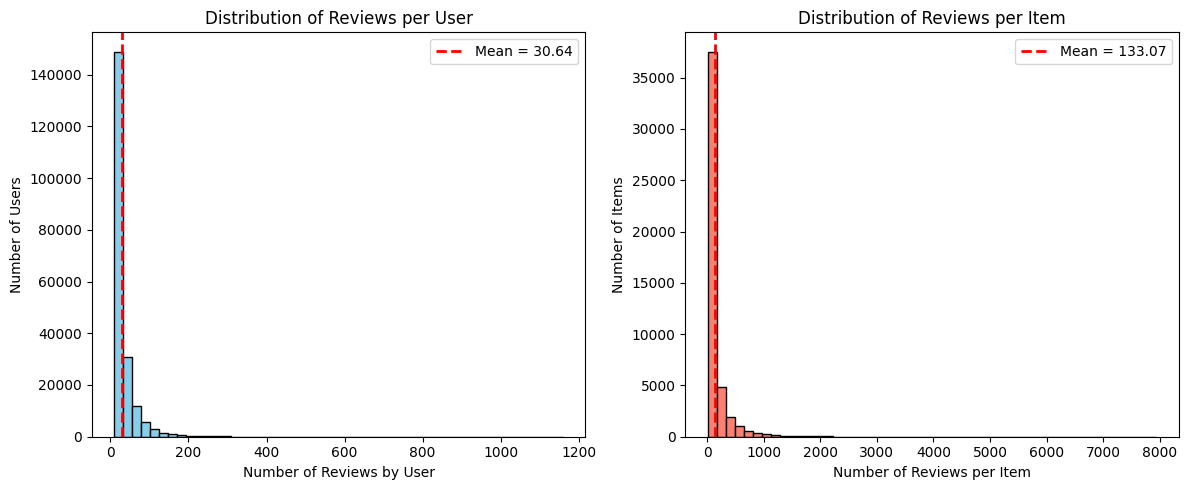

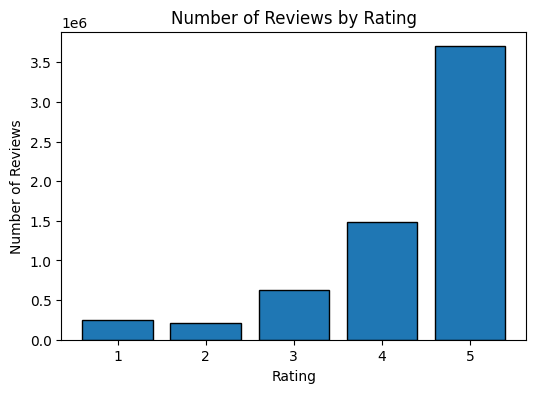

In [5]:
print("REVIEWS CHARTS: ")

# Histogram of reviews per user + item
plt.figure(figsize=(12,5))

# Reviews per user
plt.subplot(1,2,1)
plt.hist(user_interaction_counts, bins=50, color='skyblue', edgecolor='black')
plt.axvline(user_interaction_counts.mean(), color='red', linestyle='dashed', linewidth=2, label=f"Mean = {user_interaction_counts.mean():.2f}")
plt.title("Distribution of Reviews per User")
plt.xlabel("Number of Reviews by User")
plt.ylabel("Number of Users")
plt.legend()

# Reviews per item
plt.subplot(1,2,2)
plt.hist(item_interaction_counts, bins=50, color='salmon', edgecolor='black')
plt.axvline(item_interaction_counts.mean(), color='red', linestyle='dashed', linewidth=2, label=f"Mean = {item_interaction_counts.mean():.2f}")
plt.title("Distribution of Reviews per Item")
plt.xlabel("Number of Reviews per Item")
plt.ylabel("Number of Items")
plt.legend()

plt.tight_layout()

plt.savefig("user_item_dist.png")
plt.show()

rating_counts = review_df["rating"].value_counts().sort_index()

plt.figure(figsize=(6,4))
plt.bar(rating_counts.index.astype(str), rating_counts.values, edgecolor='black')

plt.title("Number of Reviews by Rating")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.savefig("reviews_by_rating.png")
plt.show()

# review_df["text_length"] = review_df["text"].fillna("").apply(len)

# print("TEXT LENGTH STATS:\n")
# print(review_df["text_length"].describe())

# plt.figure(figsize=(6,4))
# plt.hist(review_df["text_length"], bins=50, edgecolor="black")
# plt.title("Histogram: Review Text Length")
# plt.xlabel("Length (# characters)")
# plt.ylabel("Number of Reviews")
# plt.savefig("review_text_length.png")
# plt.show()

In [6]:
print("METADATA STATS: ")

print(f"Total number of places: {len(meta_df)}")

print("Columns in metadata:", list(meta_df.columns), "\n")

# Convert price symbols to numeric levels
price_levels = meta_df["price"].fillna("Unlisted").astype(str).apply(lambda x: 0 if x=="Unlisted" else len(x))
price_counts_by_length = price_levels.value_counts().sort_index()

# Map numeric levels to readable symbols
symbol_map = {0: "Unlisted", 1: "$", 2: "$$", 3: "$$$", 4: "$$$$"}
labels = [symbol_map.get(level, f"{level}-symbol") for level in price_counts_by_length.index]

# Escape $ symbols by prefixing with backslash
safe_labels = [label.replace("$", r"\$") for label in labels]

# Print counts
print("Price level counts (0 = Unlisted):")
for label, count in zip(labels, price_counts_by_length.values):
    print(f"{label}: {count}")

def parse_days_open(hours):
    days_open = [0]*7  # Monday=0 ... Sunday=6
    if isinstance(hours, list):
        for d in hours:
            day, time = d
            if str(time).lower() != "closed":
                if day == "Monday":
                    days_open[0] = 1
                elif day == "Tuesday":
                    days_open[1] = 1
                elif day == "Wednesday":
                    days_open[2] = 1
                elif day == "Thursday":
                    days_open[3] = 1
                elif day == "Friday":
                    days_open[4] = 1
                elif day == "Saturday":
                    days_open[5] = 1
                elif day == "Sunday":
                    days_open[6] = 1
    return sum(days_open)  # Total days open

# Apply to dataframe
meta_df["days_open"] = meta_df["hours"].apply(parse_days_open)

# Print stats
print("Days open per week (0 = unknown / all closed):")
print(meta_df["days_open"].value_counts().sort_index(), "\n")
print(meta_df["days_open"].describe())
print()


meta_df["desc_length"] = meta_df["description"].fillna("").apply(len)
print(meta_df["desc_length"].describe(), "\n")

print("Examples:")
print(f"Shortest description length: {meta_df['desc_length'].min()}")
print(f"Longest description length:  {meta_df['desc_length'].max()}\n")

METADATA STATS: 
Total number of places: 93476
Columns in metadata: ['name', 'address', 'gmap_id', 'description', 'latitude', 'longitude', 'category', 'avg_rating', 'num_of_reviews', 'price', 'hours', 'MISC', 'state', 'relative_results', 'url'] 

Price level counts (0 = Unlisted):
Unlisted: 78887
$: 7102
$$: 7051
$$$: 400
$$$$: 36
Days open per week (0 = unknown / all closed):
days_open
0    22426
1      947
2      509
3      884
4     2812
5    21041
6    12286
7    32571
Name: count, dtype: int64 

count    93476.000000
mean         4.522904
std          2.752176
min          0.000000
25%          1.000000
50%          5.000000
75%          7.000000
max          7.000000
Name: days_open, dtype: float64

count    93476.000000
mean        14.523418
std         33.842137
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        110.000000
Name: desc_length, dtype: float64 

Examples:
Shortest description length: 0
Longest description length:  110

METADATA PLOTS: 


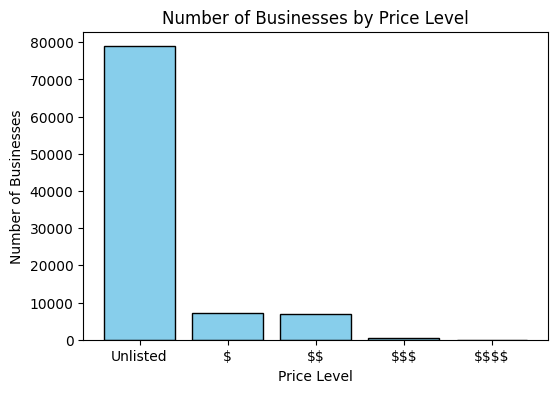

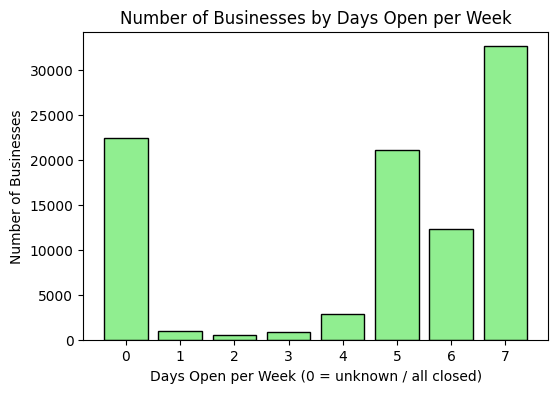

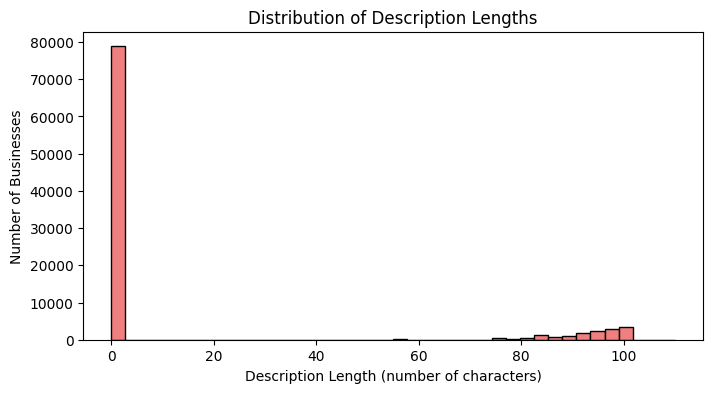

In [7]:
print("METADATA PLOTS: ")

# ---- BAR CHART ----
plt.figure(figsize=(6,4))
plt.bar(safe_labels, price_counts_by_length.values, color='skyblue', edgecolor='black')
plt.title("Number of Businesses by Price Level")
plt.xlabel("Price Level")
plt.ylabel("Number of Businesses")
plt.savefig("price_level.png")
plt.show()

# Bar chart
days_counts = meta_df["days_open"].value_counts().sort_index()
plt.figure(figsize=(6,4))
plt.bar(days_counts.index, days_counts.values, color='lightgreen', edgecolor='black')
plt.title("Number of Businesses by Days Open per Week")
plt.xlabel("Days Open per Week (0 = unknown / all closed)")
plt.ylabel("Number of Businesses")
plt.xticks(range(0,8))  # Show 0–7
plt.savefig("open_days.png")
plt.show()

# Histogram of description lengths
plt.figure(figsize=(8,4))
plt.hist(meta_df["desc_length"], bins=40, color='lightcoral', edgecolor='black')
plt.title("Distribution of Description Lengths")
plt.xlabel("Description Length (number of characters)")
plt.ylabel("Number of Businesses")
plt.savefig("desc_length.png")
plt.show()

# PREPROCESSING

In [8]:
TOP_K = 30
RANDOM_SEED = 42
POS_THRESHOLD = 4

RATIO_FOR_REVEALED = 0.8

FULL_LIKES_DATA_FNAME = "users_likes_full.json"
REVEALED_LIKES_DATA_FNAME = "users_revealed_likes.json"
HIDDEN_LIKES_DATA_FNAME = "users_hidden_likes.json"

ITER_UPDATE_REC_FNAME = "iterative_update_recommendation_per_user.json"
BPR_REC_FNAME = "bpr_recommendation_per_user.json"
BASELINE_REC_FNAME = "baseline_recommendation_per_user.json"
SVD_REC_FNAME = "svd_recommendation_per_user.json"
LIGHT_FM_REC_FNAME = "light_fm_recommendation_per_user.json"
LIGHT_GBM_REC_FNAME = "light_gbm_recommendation_per_user.json"

# keys: "ITER_UPDATE", "BPR", "BASELINE", "SVD", "LIGHT_FM", "LIGHT_GBM"
train_time = {}
rec_time = {}

MIN_INTERACTIONS_PER_USER = 1
MAX_INTERACTIONS = 200000
MAX_USERS = MAX_INTERACTIONS
MAX_ITEMS = MAX_INTERACTIONS

In [9]:
reviews = reviews[:MAX_INTERACTIONS]

df = pd.DataFrame(reviews)

df_pos = df[df["rating"] >= POS_THRESHOLD].copy()

user_counts = df_pos["user_id"].value_counts()
eligible_users = user_counts[user_counts >= MIN_INTERACTIONS_PER_USER].index

df_pos = df_pos[df_pos["user_id"].isin(eligible_users)].reset_index(drop=True)

# Limiting the unique users and items. This is done for the sake of time.
# For the record, we tried running this without the limitation and the score we got was negligibly similar to the one with this limitation.
unique_users = df_pos["user_id"].unique()
if MAX_USERS is not None:
    unique_users = unique_users[:MAX_USERS]

df_pos = df_pos[df_pos["user_id"].isin(unique_users)]

unique_items = df_pos["gmap_id"].unique()
if MAX_ITEMS is not None:
    unique_items = unique_items[:MAX_ITEMS]

df_pos = df_pos[df_pos["gmap_id"].isin(unique_items)].reset_index(drop=True)

user_id_to_idx = {u: idx for idx, u in enumerate(unique_users)}
item_id_to_idx = {i: idx for idx, i in enumerate(unique_items)}

df_pos["user_idx"] = df_pos["user_id"].map(user_id_to_idx)
df_pos["item_idx"] = df_pos["gmap_id"].map(item_id_to_idx)

num_users = len(user_id_to_idx)
num_items = len(item_id_to_idx)


# Shuffle rows (if no timestamp, just randomize)
if "time" in df_pos.columns:
    df_pos = df_pos.sort_values(["user_idx", "time"])
else:
    df_pos = df_pos.sample(frac=1.0, random_state=RANDOM_SEED)

train_rows = []
test_rows = []

# Split each user's interactions 80:20
for user_id, group in df_pos.groupby("user_id"):
    idx_list = group.index.tolist()
    random.shuffle(idx_list)
    
    split_point = max(1, int(RATIO_FOR_REVEALED * len(idx_list)))  # ensure at least 1 row in train
    train_rows.extend(idx_list[:split_point])
    test_rows.extend(idx_list[split_point:])

train_df = df_pos.loc[train_rows].reset_index(drop=True)
test_df = df_pos.loc[test_rows].reset_index(drop=True)

# Get a translation dictionary so we know the user and location id we're referring to by their idx after the fitting
idx_to_user_id = {idx: u for u, idx in user_id_to_idx.items()}
idx_to_item_id = {idx: i for i, idx in item_id_to_idx.items()}


interactions_train = list(
    zip(
        train_df["user_idx"].astype(int).tolist(),
        train_df["item_idx"].astype(int).tolist(),
        train_df["rating"].tolist()
    )
)

items_per_user_train = defaultdict(set)
for u, i, r in interactions_train:
    items_per_user_train[u].add(i)

all_items = list(range(num_items))

test_items_per_user = defaultdict(list)
for _, row in test_df.iterrows():
    u = int(row["user_idx"])
    i = int(row["item_idx"])
    test_items_per_user[u].append(i)

In [10]:
users_total_likes = defaultdict(list)

# save the revealed likes
users_revealed_likes = defaultdict(list)

for _, row in train_df.iterrows():
    user_id = idx_to_user_id[row["user_idx"]]
    item_id = idx_to_item_id[row["item_idx"]]
    users_revealed_likes[user_id].append(item_id)
    users_total_likes[user_id].append(item_id)

users_revealed_likes = dict(users_revealed_likes)

# save the hidden likes
users_hidden_likes = defaultdict(list)

for _, row in test_df.iterrows():
    user_id = idx_to_user_id[row["user_idx"]]
    item_id = idx_to_item_id[row["item_idx"]]
    users_hidden_likes[user_id].append(item_id)
    users_total_likes[user_id].append(item_id)

users_hidden_likes = dict(users_hidden_likes)

users_total_likes = dict(users_total_likes)

# Saving the likes specific for this
# This is because of the 100000 limiting of users and items as done above
save_likes(REVEALED_LIKES_DATA_FNAME, users_revealed_likes)
save_likes(HIDDEN_LIKES_DATA_FNAME, users_hidden_likes)
save_likes(FULL_LIKES_DATA_FNAME, users_total_likes)

Saved to  eval/users_revealed_likes.json
Saved to  eval/users_hidden_likes.json
Saved to  eval/users_likes_full.json


# Bayesian Personalized Ranking (BPR) Model

In [11]:
# BPR-specific variables
LATENT_DIM = 64
LEARNING_RATE = 0.01
REG_LAMBDA = 1e-5
NSAMPLES_PER_BATCH = 50000
N_TRAIN_STEPS = 1000

# Extra pre-processing for bpr
random.seed(RANDOM_SEED)
numpy.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [12]:
# The model we're using
class BPRbatch(tf.keras.Model):
    def __init__(self, K, lamb):
        super().__init__()
        self.lamb = lamb

        # Global item bias
        self.betaI = self.add_weight(
            name="betaI",
            shape=(num_items,),
            initializer=tf.random_normal_initializer(stddev=0.001),
            trainable=True,
        )

        # User latent factors
        self.gammaU = self.add_weight(
            name="gammaU",
            shape=(num_users, K),
            initializer=tf.random_normal_initializer(stddev=0.001),
            trainable=True,
        )

        # Item latent factors
        self.gammaI = self.add_weight(
            name="gammaI",
            shape=(num_items, K),
            initializer=tf.random_normal_initializer(stddev=0.001),
            trainable=True,
        )

    def score(self, sampleU, sampleI):
        # sampleU, sampleI are index tensors
        u = tf.cast(sampleU, tf.int32)
        i = tf.cast(sampleI, tf.int32)

        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        gamma_u = tf.nn.embedding_lookup(self.gammaU, u)
        gamma_i = tf.nn.embedding_lookup(self.gammaI, i)

        x_ui = beta_i + tf.reduce_sum(gamma_u * gamma_i, axis=1)
        return x_ui

    def call(self, sampleU, sampleI, sampleJ):
        x_ui = self.score(sampleU, sampleI)
        x_uj = self.score(sampleU, sampleJ)
        # BPR loss: -log σ(x_ui - x_uj)
        loss = -tf.reduce_mean(tf.math.log_sigmoid(x_ui - x_uj))
        return loss

    def reg(self):
        return self.lamb * (
            tf.nn.l2_loss(self.betaI)
            + tf.nn.l2_loss(self.gammaU)
            + tf.nn.l2_loss(self.gammaI)
        )

In [13]:
start_time = time.time()

# Training the model
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
modelBPR = BPRbatch(LATENT_DIM, REG_LAMBDA)

def trainingStepBPR(model, interactions, items_per_user, items, Nsamples):
    sampleU, sampleI, sampleJ = [], [], []

    for _ in range(Nsamples):
        u, i, r = random.choice(interactions)
        j = random.choice(items)
        while j in items_per_user[u]:
            j = random.choice(items)

        sampleU.append(u)
        sampleI.append(i)
        sampleJ.append(j)

    # Convert lists → tensors
    sampleU_tf = tf.convert_to_tensor(sampleU, dtype=tf.int32)
    sampleI_tf = tf.convert_to_tensor(sampleI, dtype=tf.int32)
    sampleJ_tf = tf.convert_to_tensor(sampleJ, dtype=tf.int32)

    with tf.GradientTape() as tape:
        loss = model(sampleU_tf, sampleI_tf, sampleJ_tf)
        loss += model.reg()

    grads = tape.gradient(loss, model.trainable_variables)

    # Pair gradients with variables, skipping any None grads just in case
    grads_and_vars = [
        (g, v) for g, v in zip(grads, model.trainable_variables) if g is not None
    ]

    if grads_and_vars:
        optimizer.apply_gradients(grads_and_vars)
    else:
        print("Warning: no gradients to apply this step.")

    return float(loss.numpy())

loss_history = []

# Run the training
first_batch_loss = trainingStepBPR(
    modelBPR,
    interactions_train,
    items_per_user_train,
    all_items,
    Nsamples=NSAMPLES_PER_BATCH  # mini testing
)

loss_history.append(first_batch_loss)

print(f"One mini-batch objective: {first_batch_loss :.4f}")

for step in range(N_TRAIN_STEPS):
    obj = trainingStepBPR(
        modelBPR,
        interactions_train,
        items_per_user_train,
        all_items,
        NSAMPLES_PER_BATCH,
    )
    loss_history.append(obj)
    if (step + 1) % 5 == 0:
        print(f"Step {step + 1}, objective = {obj:.4f}")

end_time = time.time()
train_time["BPR"] = end_time - start_time

One mini-batch objective: 0.6932
Step 5, objective = 0.6841
Step 10, objective = 0.6754
Step 15, objective = 0.6676
Step 20, objective = 0.6597
Step 25, objective = 0.6526
Step 30, objective = 0.6454
Step 35, objective = 0.6371
Step 40, objective = 0.6298
Step 45, objective = 0.6200
Step 50, objective = 0.6107
Step 55, objective = 0.6032
Step 60, objective = 0.5965
Step 65, objective = 0.5889
Step 70, objective = 0.5809
Step 75, objective = 0.5751
Step 80, objective = 0.5683
Step 85, objective = 0.5663
Step 90, objective = 0.5647
Step 95, objective = 0.5630
Step 100, objective = 0.5599
Step 105, objective = 0.5603
Step 110, objective = 0.5567
Step 115, objective = 0.5570
Step 120, objective = 0.5552
Step 125, objective = 0.5560
Step 130, objective = 0.5554
Step 135, objective = 0.5558
Step 140, objective = 0.5545
Step 145, objective = 0.5538
Step 150, objective = 0.5521
Step 155, objective = 0.5527
Step 160, objective = 0.5530
Step 165, objective = 0.5520
Step 170, objective = 0.5507
S

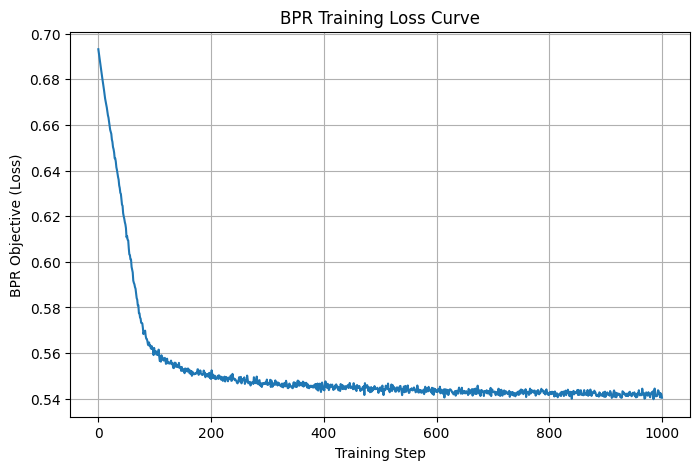

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(loss_history)
plt.xlabel("Training Step")
plt.ylabel("BPR Objective (Loss)")
plt.title("BPR Training Loss Curve")
plt.grid(True)
plt.savefig("bpr_loss.png")
plt.show()

In [15]:
start_time = time.time()

def get_top_k_recommendations(model, train_items_per_user, test_items_per_user, items, k, idx_to_user_id, idx_to_item_id):
    """
    Returns: dict of user_id -> list of top-k gmap_ids, excluding training items.
    """
    recs = {}
    users = list(test_items_per_user.keys())
    all_items_array = numpy.array(items, dtype=numpy.int32)

    for u in tqdm(users, desc="Generating recommendations"):
        user_id = idx_to_user_id[u]

        train_items = train_items_per_user[u]

        # Candidate items = all items not already interacted with
        candidate_mask = ~numpy.isin(all_items_array, list(train_items))
        candidate_items = all_items_array[candidate_mask]

        if len(candidate_items) == 0:
            recs[user_id] = []
            continue

        # Score all candidate items
        u_list = numpy.full(len(candidate_items), u, dtype=numpy.int32)
        scores = model.score(u_list, candidate_items).numpy()

        # Sort scores and get top-k
        top_idx = numpy.argsort(-scores)[:k]  # sorted descending
        top_item_indices_sorted = candidate_items[top_idx]

        # Map indices back to gmap_ids
        top_item_ids = [idx_to_item_id[i] for i in top_item_indices_sorted]

        recs[user_id] = top_item_ids

    return recs

# Running the function and getting the recommendations
recs = get_top_k_recommendations(
    modelBPR,
    items_per_user_train,
    test_items_per_user,
    all_items,
    TOP_K,
    idx_to_user_id,
    idx_to_item_id
)

save_likes(BPR_REC_FNAME, recs)

end_time = time.time()
rec_time["BPR"] = end_time - start_time

Generating recommendations: 100%|████████████████████████████████████████████████| 38800/38800 [02:39<00:00, 243.96it/s]


Saved to  eval/bpr_recommendation_per_user.json


# Singlular Vector Decomposition (SVD) Model

SVD one mini-batch objective: 0.6932
SVD Step 5, objective = 0.6887
SVD Step 10, objective = 0.6844
SVD Step 15, objective = 0.6806
SVD Step 20, objective = 0.6769
SVD Step 25, objective = 0.6733
SVD Step 30, objective = 0.6704
SVD Step 35, objective = 0.6680
SVD Step 40, objective = 0.6656
SVD Step 45, objective = 0.6632
SVD Step 50, objective = 0.6602
SVD Step 55, objective = 0.6582
SVD Step 60, objective = 0.6564
SVD Step 65, objective = 0.6554
SVD Step 70, objective = 0.6542
SVD Step 75, objective = 0.6529
SVD Step 80, objective = 0.6520
SVD Step 85, objective = 0.6514
SVD Step 90, objective = 0.6512
SVD Step 95, objective = 0.6504
SVD Step 100, objective = 0.6502
SVD Step 105, objective = 0.6510
SVD Step 110, objective = 0.6505
SVD Step 115, objective = 0.6503
SVD Step 120, objective = 0.6498
SVD Step 125, objective = 0.6494
SVD Step 130, objective = 0.6509
SVD Step 135, objective = 0.6488
SVD Step 140, objective = 0.6493
SVD Step 145, objective = 0.6495
SVD Step 150, objective = 

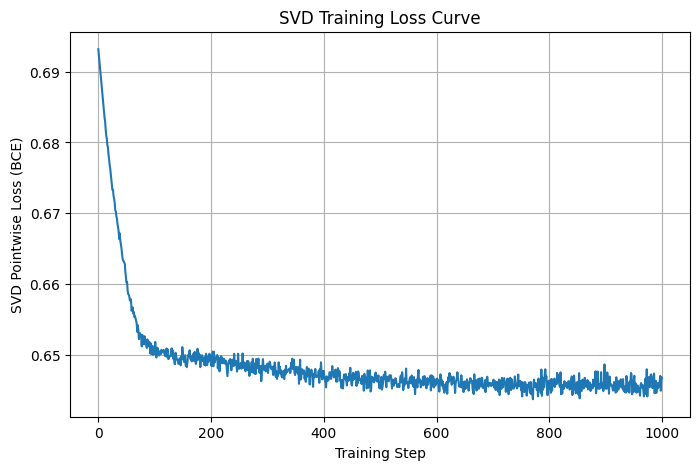

Generating SVD recommendations: 100%|████████████████████████████████████████████| 38800/38800 [03:03<00:00, 211.30it/s]


Saved to  eval/svd_recommendation_per_user.json


In [16]:
class SVDbatch(tf.keras.Model):
    def __init__(self, K, lamb):
        super().__init__()
        self.lamb = lamb

        # Global item bias (same shape as BPR for compatibility)
        self.betaI = self.add_weight(
            name="betaI",
            shape=(num_items,),
            initializer=tf.random_normal_initializer(stddev=0.001),
            trainable=True,
        )

        # Global user bias (optional but common in SVD)
        self.betaU = self.add_weight(
            name="betaU",
            shape=(num_users,),
            initializer=tf.random_normal_initializer(stddev=0.001),
            trainable=True,
        )

        # User latent factors
        self.gammaU = self.add_weight(
            name="gammaU",
            shape=(num_users, K),
            initializer=tf.random_normal_initializer(stddev=0.001),
            trainable=True,
        )

        # Item latent factors
        self.gammaI = self.add_weight(
            name="gammaI",
            shape=(num_items, K),
            initializer=tf.random_normal_initializer(stddev=0.001),
            trainable=True,
        )

    def score(self, sampleU, sampleI):
        """
        Return predicted score for user-item index pairs (dot + biases).
        sampleU and sampleI are int32 tensors or numpy arrays of indices.
        """
        u = tf.cast(sampleU, tf.int32)
        i = tf.cast(sampleI, tf.int32)

        b_i = tf.nn.embedding_lookup(self.betaI, i)
        b_u = tf.nn.embedding_lookup(self.betaU, u)
        g_u = tf.nn.embedding_lookup(self.gammaU, u)
        g_i = tf.nn.embedding_lookup(self.gammaI, i)

        # predicted logit (no final activation) — higher = more likely interaction
        x_ui = b_i + b_u + tf.reduce_sum(g_u * g_i, axis=1)
        return x_ui

    def call(self, sampleU, sampleI, labels):
        """
        Compute pointwise binary cross-entropy loss for logits and labels.
        labels should be float32 tensor same shape as logits (0.0 or 1.0).
        """
        logits = self.score(sampleU, sampleI)
        # Use tf.nn.sigmoid_cross_entropy_with_logits for numerical stability
        bce = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits)
        loss = tf.reduce_mean(bce)
        return loss

    def reg(self):
        return self.lamb * (
            tf.nn.l2_loss(self.betaI)
            + tf.nn.l2_loss(self.betaU)
            + tf.nn.l2_loss(self.gammaU)
            + tf.nn.l2_loss(self.gammaI)
        )

# Training step for SVD
optimizer_svd = tf.keras.optimizers.Adam(LEARNING_RATE)
modelSVD = SVDbatch(LATENT_DIM, REG_LAMBDA)

def trainingStepSVD(model, interactions, items_per_user, items, Nsamples):
    """
    For each sampled positive interaction, sample one negative item for the same user.
    We'll produce a batch of size 2 * Nsamples with labels (1 for pos, 0 for neg).
    interactions: list of (u, i, r) where u and i are indices (same as in your BPR loop).
    items_per_user: dict mapping user_idx -> set/list of item indices they interacted with.
    items: list/array of all item indices.
    """
    sampleU_pos, sampleI_pos = [], []
    sampleU_neg, sampleI_neg = [], []

    # Draw Nsamples positives and Nsamples negatives
    for _ in range(Nsamples):
        u, i, r = random.choice(interactions)  # assuming interactions hold (user_idx, item_idx, rating)
        # sample a negative item not in user's training items
        j = random.choice(items)
        while j in items_per_user[u]:
            j = random.choice(items)

        sampleU_pos.append(u)
        sampleI_pos.append(i)

        sampleU_neg.append(u)
        sampleI_neg.append(j)

    # Concatenate pos and neg to create one batch
    sampleU = tf.convert_to_tensor(sampleU_pos + sampleU_neg, dtype=tf.int32)
    sampleI = tf.convert_to_tensor(sampleI_pos + sampleI_neg, dtype=tf.int32)

    # labels: 1 for positives, 0 for negatives
    labels = tf.convert_to_tensor([1.0] * Nsamples + [0.0] * Nsamples, dtype=tf.float32)

    with tf.GradientTape() as tape:
        loss = model(sampleU, sampleI, labels)
        loss += model.reg()

    grads = tape.gradient(loss, model.trainable_variables)

    grads_and_vars = [(g, v) for g, v in zip(grads, model.trainable_variables) if g is not None]

    if grads_and_vars:
        optimizer_svd.apply_gradients(grads_and_vars)
    else:
        print("Warning: no gradients to apply this step for SVD.")

    return float(loss.numpy())

start_time = time.time()

# Train SVD 
loss_history_svd = []

# warm-up batch
first_batch_loss_svd = trainingStepSVD(
    modelSVD,
    interactions_train,
    items_per_user_train,
    all_items,
    Nsamples=NSAMPLES_PER_BATCH
)
loss_history_svd.append(first_batch_loss_svd)
print(f"SVD one mini-batch objective: {first_batch_loss_svd:.4f}")

for step in range(N_TRAIN_STEPS):
    obj = trainingStepSVD(
        modelSVD,
        interactions_train,
        items_per_user_train,
        all_items,
        Nsamples=NSAMPLES_PER_BATCH,
    )
    loss_history_svd.append(obj)
    if (step + 1) % 5 == 0:
        print(f"SVD Step {step + 1}, objective = {obj:.4f}")

end_time = time.time()
train_time["SVD"] = end_time - start_time

plt.figure(figsize=(8,5))
plt.plot(loss_history_svd)
plt.xlabel("Training Step")
plt.ylabel("SVD Pointwise Loss (BCE)")
plt.title("SVD Training Loss Curve")
plt.grid(True)
plt.savefig("svd_loss.png")
plt.show()

# Recommendation (same as BPR)
def get_top_k_recommendations_svd(model, train_items_per_user, test_items_per_user, items, k, idx_to_user_id, idx_to_item_id):
    """
    Returns: dict of user_id -> list of top-k gmap_ids, excluding training items.
    Uses model.score(...) to compute logits and ranks by descending.
    """
    recs = {}
    users = list(test_items_per_user.keys())
    all_items_array = numpy.array(items, dtype=numpy.int32)

    for u in tqdm(users, desc="Generating SVD recommendations"):
        user_id = idx_to_user_id[u]
        train_items = train_items_per_user[u]

        # Candidate items = all items not already interacted with
        candidate_mask = ~numpy.isin(all_items_array, list(train_items))
        candidate_items = all_items_array[candidate_mask]

        if len(candidate_items) == 0:
            recs[user_id] = []
            continue

        u_list = numpy.full(len(candidate_items), u, dtype=numpy.int32)
        # model.score expects tensors/arrays of indices
        scores = model.score(u_list, candidate_items).numpy()

        top_idx = numpy.argsort(-scores)[:k]  # descending
        top_item_indices_sorted = candidate_items[top_idx]
        top_item_ids = [idx_to_item_id[i] for i in top_item_indices_sorted]

        recs[user_id] = top_item_ids

    return recs

start_time = time.time()

recs_svd = get_top_k_recommendations_svd(
    modelSVD,
    items_per_user_train,
    test_items_per_user,
    all_items,
    TOP_K,
    idx_to_user_id,
    idx_to_item_id
)

save_likes(SVD_REC_FNAME, recs_svd)   # change filename as you like

end_time = time.time()
rec_time["SVD"] = end_time - start_time

# Light GBM Model

In [20]:
start_time = time.time()

# Get embeddings from BPR
U_bpr = modelBPR.gammaU.numpy()
I_bpr = modelBPR.gammaI.numpy()

import numpy as np
import random
import lightgbm as lgb

train_features = []
train_labels = []
group_sizes = []

NEG_PER_USER = 50  # can tune

for u in range(num_users):
    pos_items = list(items_per_user_train[u])

    # sample negatives
    neg_items = random.sample(all_items, min(NEG_PER_USER, len(all_items)))
    neg_items = [i for i in neg_items if i not in pos_items]

    # for group sizes (LightGBM uses N items per user)
    group_sizes.append(len(pos_items) + len(neg_items))

    # build positive examples
    for i in pos_items:
        f = np.concatenate([U_bpr[u], I_bpr[i]])
        train_features.append(f)
        train_labels.append(1)

    # build negative examples
    for j in neg_items:
        f = np.concatenate([U_bpr[u], I_bpr[j]])
        train_features.append(f)
        train_labels.append(0)

train_features = np.array(train_features)
train_labels = np.array(train_labels)

  0%|                                                                                           | 0/100 [00:00<?, ?it/s]

[LightGBM] [Info] Total Bins 32640
[LightGBM] [Info] Number of data points in the train set: 4747720, number of used features: 128


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.25s/it]


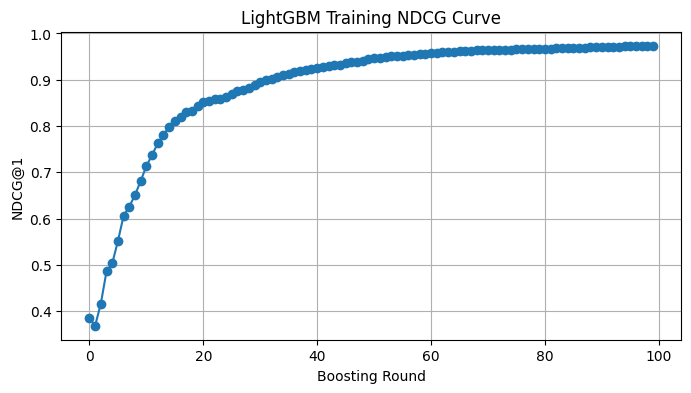

In [21]:
train_dataset = lgb.Dataset(
    train_features,
    label=train_labels,
    group=group_sizes
)

params = {
    "objective": "lambdarank",
    "metric": "ndcg",
    "learning_rate": 0.05,
    "num_leaves": 32,
    "min_data_in_leaf": 20,
}

params["force_row_wise"] = True
params["histogram_pool_size"] = 1024

def tqdm_callback(total):
    pbar = tqdm(total=total)
    def _callback(env):
        # Update progress bar each iteration
        if env.iteration < total:
            pbar.update(1)

        # Close progress bar on last iteration
        if env.iteration == total - 1:
            pbar.close()

    return _callback


evals_result = {}

record_eval_cb = lgb.record_evaluation(evals_result)

model_lgb = lgb.train(
    params,
    train_dataset,
    num_boost_round=100,
    valid_sets=[train_dataset],
    callbacks=[tqdm_callback(100), record_eval_cb]
)

end_time = time.time()
train_time["LIGHT_GBM"] = end_time - start_time



In [45]:
list(evals_result['training'].keys())

['ndcg@1', 'ndcg@2', 'ndcg@3', 'ndcg@4', 'ndcg@5']

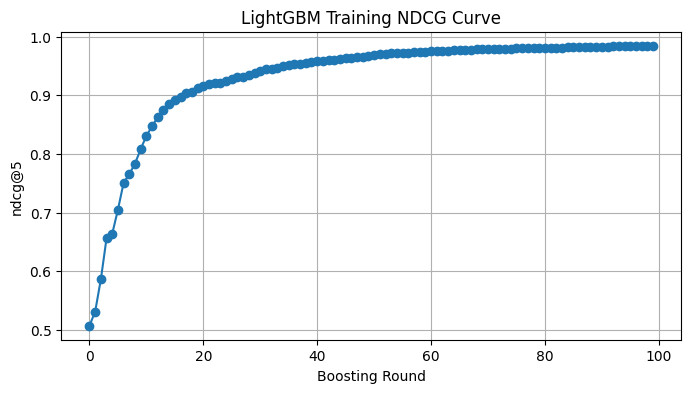

In [46]:
# evals_result now contains the metric at each iteration
# For example: NDCG at first group (dataset index 0)
ndcg_values = evals_result['training']['ndcg@5']  # or 'ndcg@3' etc.

# Plot the curve
plt.figure(figsize=(8,4))
plt.plot(ndcg_values, marker='o')
plt.title("LightGBM Training NDCG Curve")
plt.xlabel("Boosting Round")
plt.ylabel("ndcg@5")
plt.grid(True)
plt.savefig("lgbm_ndcg.png")
plt.show()

In [23]:
def get_top_k_recommendations_lgb_fast(
    model, U, I,
    train_items_per_user, test_items_per_user,
    k, idx_to_user_id, idx_to_item_id
):
    recs = {}
    all_items_array = numpy.arange(len(I))  # all item indices
    users = list(test_items_per_user.keys())

    for u in tqdm(users, desc="LightGBM recommendations"):
        user_id = idx_to_user_id[u]
        train_items = set(train_items_per_user[u])

        # Candidate items (all items except training items)
        candidate_mask = ~numpy.isin(all_items_array, list(train_items))
        candidate_items = all_items_array[candidate_mask]

        if len(candidate_items) == 0:
            recs[user_id] = []
            continue

        # Vectorized feature creation
        # Repeat user features len(candidate_items) times
        user_feats = numpy.repeat(U[u:u+1], len(candidate_items), axis=0)
        item_feats = I[candidate_items]
        feats = numpy.hstack([user_feats, item_feats])

        # Predict scores for all candidate items at once
        scores = model.predict(feats)

        # Get top-k indices
        top_idx = numpy.argsort(-scores)[:k]
        top_items = candidate_items[top_idx]
        recs[user_id] = [idx_to_item_id[i] for i in top_items]

    return recs

start_time = time.time()

# Run the recommendation function
recs_lgb = get_top_k_recommendations_lgb_fast(
    model_lgb, U_bpr, I_bpr,
    items_per_user_train,
    test_items_per_user,
    TOP_K,
    idx_to_user_id,
    idx_to_item_id
)

save_likes(LIGHT_GBM_REC_FNAME, recs_lgb)

end_time = time.time()
rec_time["LIGHT_GBM"] = end_time - start_time

LightGBM recommendations: 100%|███████████████████████████████████████████████████| 38800/38800 [12:32<00:00, 51.56it/s]


Saved to  eval/light_gbm_recommendation_per_user.json


# Iterative Update Model

In [24]:
# The functions we'll use for to update in the iterations

def getGlobalAverage(trainRatings):
    # Return the average rating in the training set
    res = numpy.average(trainRatings)
    return res

def alphaUpdate(ratingsTrain, alpha, betaU, betaLoc, lamb):
    # Update equation for alpha
    newAlpha = 0

    # From slide 83 of the recommendation slide
    # alpha = sum_{u,i in train} (R_u,i - (betaU + betaLoc)) / Ntrain
    Ntrain = len(ratingsTrain)

    for u, loc, rating in ratingsTrain:
        # u, loc, rating = r["user_id"], r["gmap_id"], r["rating"]

        newAlpha += rating - (betaU[u] + betaLoc[loc])
    
    newAlpha /= Ntrain

    return newAlpha

def betaUUpdate(ratingsPerUser, alpha, betaU, betaLoc, lamb):
    # Update equation for betaU
    newBetaU = {}

    # From slide 83 of the recommendation slide
    # betaU = sum_{i in I_u} (R_u,i - (alpha + betaLoc)) / (lamb + |I_u|)
    
    # Structure is ratingsPerUser[user] = [(location, rating)]
    # betaU[user] = how much does this user tend to rate things above mean

    for u in ratingsPerUser:
        curr = 0
        
        for i, r in ratingsPerUser[u]:
            curr += r - (alpha + betaLoc[i])
    
        curr /= (lamb + len(ratingsPerUser[u]))

        newBetaU[u] = curr

    return newBetaU

def betaLocUpdate(ratingsPerLocation, alpha, betaU, betaLoc, lamb):
    # Update equation for betaLoc
    newBetaLoc = {}

    # From slide 83 of the recommendation slide
    # betaU = sum_{u in U_i} (R_u,i - (alpha + betaU)) / (lamb + |U_i|)

    # ratingsPerLocation[location] = [(user, rating)]

    for i in ratingsPerLocation:
        curr = 0

        for u, r in ratingsPerLocation[i]:
            curr += r - (alpha + betaU[u])
        
        curr /= (lamb + len(ratingsPerLocation[i]))

        newBetaLoc[i] = curr

    return newBetaLoc

In [25]:
# The model we're using
def iterativeUpdateModel(ratingsTrain, ratingsPerUser, ratingsPerLocation, alpha, betaU, betaLoc):
    # Improve upon your model from the previous question (e.g. by running multiple iterations)

    # Running multiple iterations
    lamb = 0.5
    for i in range(100):
        alpha = alphaUpdate(ratingsTrain, alpha, betaU, betaLoc, lamb)
        betaU = betaUUpdate(ratingsPerUser, alpha, betaU, betaLoc, lamb)
        betaLoc = betaLocUpdate(ratingsPerLocation, alpha, betaU, betaLoc, lamb)

    return alpha, betaU, betaLoc

In [26]:
start_time = time.time()

# Prepare training data using item indices
ratingsTrain = []
ratingsPerUser = defaultdict(list)
ratingsPerLocation = defaultdict(list)

for _, row in train_df.iterrows():
    u = int(row["user_idx"])
    i = int(row["item_idx"])
    r = float(row["rating"])
    
    ratingsTrain.append((u, i, r))
    ratingsPerUser[u].append((i, r))
    ratingsPerLocation[i].append((u, r))

# Initialize parameters
trainRatings = [r for _, _, r in ratingsTrain]
betaU = {u: 0 for u in ratingsPerUser}
betaLoc = {i: 0 for i in ratingsPerLocation}
alpha = getGlobalAverage(trainRatings)

# Train the model
alpha, betaU, betaLoc = iterativeUpdateModel(ratingsTrain, ratingsPerUser, ratingsPerLocation, alpha, betaU, betaLoc)

end_time = time.time()
train_time["ITER_UPDATE"] = end_time - start_time

In [27]:
start_time = time.time()

# Generate recommendations using the same structure as baseline/model
recs = {}
users = list(test_items_per_user.keys())
all_items_array = numpy.array(all_items, dtype=numpy.int32)

for u in tqdm(users, desc="Generating iterative update recommendations"):
    user_id = idx_to_user_id[u]
    train_items = items_per_user_train[u]
    
    # Candidate items = all items not already interacted with
    candidate_mask = ~numpy.isin(all_items_array, list(train_items))
    candidate_items = all_items_array[candidate_mask]
    
    if len(candidate_items) == 0:
        recs[user_id] = []
        continue
    
    # Score all candidate items using the bias model
    bu = betaU.get(u, 0)
    scores = numpy.array([alpha + bu + betaLoc.get(i, 0) for i in candidate_items])
    
    # Sort by score and get top-k
    top_idx = numpy.argsort(-scores)[:TOP_K]  # sorted descending
    top_item_indices_sorted = candidate_items[top_idx]
    
    # Map indices back to gmap_ids
    top_item_ids = [idx_to_item_id[i] for i in top_item_indices_sorted]
    recs[user_id] = top_item_ids

# Export to json
save_likes(ITER_UPDATE_REC_FNAME, recs)

end_time = time.time()
rec_time["ITER_UPDATE"] = end_time - start_time

Generating iterative update recommendations: 100%|████████████████████████████████| 38800/38800 [07:12<00:00, 89.65it/s]


Saved to  eval/iterative_update_recommendation_per_user.json


# Baseline Model

In [35]:
train_time["BASELINE"] = 0

start_time = time.time()

# Preprocessing the data; get the number of reviews per store in the metadata
locations_review_count = defaultdict(int)
locations_avg_rating = defaultdict(int)

# First get the count of all the reviews for each location
for review in reviews:
    locations_review_count[review["gmap_id"]] += 1

# Get the average rating listed in the metadata
for m in metadata:
    locations_avg_rating[m["gmap_id"]] = m["avg_rating"]

# Calculate popularity score for each location
locations_popularity = defaultdict(int)
for gmap_id in locations_review_count:
    locations_popularity[gmap_id] = locations_review_count[gmap_id] * locations_avg_rating[gmap_id]

# Create a mapping from item_idx to popularity score
item_popularity = {}
for item_idx in all_items:
    gmap_id = idx_to_item_id[item_idx]
    item_popularity[item_idx] = locations_popularity.get(gmap_id, 0)

# Generate baseline recommendations using the same structure
recs = {}
users = list(test_items_per_user.keys())
all_items_array = numpy.array(all_items, dtype=numpy.int32)

for u in tqdm(users, desc="Generating baseline recommendations"):
    user_id = idx_to_user_id[u]
    train_items = items_per_user_train[u]
    
    # Candidate items = all items not already interacted with
    candidate_mask = ~numpy.isin(all_items_array, list(train_items))
    candidate_items = all_items_array[candidate_mask]
    
    if len(candidate_items) == 0:
        recs[user_id] = []
        continue
    
    # Get popularity scores for candidate items
    candidate_popularity = numpy.array([item_popularity.get(i, 0) for i in candidate_items])
    
    # Sort by popularity and get top-k
    top_idx = numpy.argsort(-candidate_popularity)[:TOP_K]  # sorted descending
    top_item_indices_sorted = candidate_items[top_idx]
    
    # Map indices back to gmap_ids
    top_item_ids = [idx_to_item_id[i] for i in top_item_indices_sorted]
    recs[user_id] = top_item_ids

# Export to json
save_likes(BASELINE_REC_FNAME, recs)

end_time = time.time()
rec_time["BASELINE"] = end_time - start_time

Generating baseline recommendations: 100%|███████████████████████████████████████| 38800/38800 [05:58<00:00, 108.27it/s]


Saved to  eval/baseline_recommendation_per_user.json


In [29]:
def evalFunc(recs_fname, hidden_fname):
    recs = load_user_likes(recs_fname)
    hidden = load_user_likes(hidden_fname)

    hit_scores = {}

    for user_id, hidden_items in hidden.items():
        recommended_items = recs[user_id]

        hits = sum(1 for item in hidden_items if item in recommended_items)
        
        hit_for_this_user = 1 if hits > 0 else 0
        
        hit_scores[user_id] = hit_for_this_user

    # average performance across all users
    overall_score = sum(hit_scores.values()) / len(hit_scores)

    print("Overall Hitrate@k score: ",overall_score)

    return overall_score, hit_scores

In [30]:
# Running the evaluations

print("Evaluation for Iterative Update Model")
iter_score, iter_hits = evalFunc(ITER_UPDATE_REC_FNAME, HIDDEN_LIKES_DATA_FNAME)

print("Evaluation for BPR Model")
bpr_score, bpr_hits = evalFunc(BPR_REC_FNAME, HIDDEN_LIKES_DATA_FNAME)

print("Evaluation for Baseline Model")
base_score, base_hits = evalFunc(BASELINE_REC_FNAME, HIDDEN_LIKES_DATA_FNAME)

print("Evaluation for SVD Model")
svd_score, svd_hits = evalFunc(SVD_REC_FNAME, HIDDEN_LIKES_DATA_FNAME)

Evaluation for Iterative Update Model
Overall Hitrate@k score:  0.002577319587628866
Evaluation for BPR Model
Overall Hitrate@k score:  0.08115979381443299
Evaluation for Baseline Model
Overall Hitrate@k score:  0.05724226804123712
Evaluation for SVD Model
Overall Hitrate@k score:  0.059278350515463915


In [31]:
print("Evaluation for Light FM Model")
light_fm_score, light_fm_hits = evalFunc(LIGHT_FM_REC_FNAME, HIDDEN_LIKES_DATA_FNAME)

Evaluation for Light FM Model
Overall Hitrate@k score:  0.0033505154639175256


In [32]:
print("Evaluation for Light GBM Model")
light_gbm_score, light_gbm_hits = evalFunc(LIGHT_GBM_REC_FNAME, HIDDEN_LIKES_DATA_FNAME)

Evaluation for Light GBM Model
Overall Hitrate@k score:  0.13


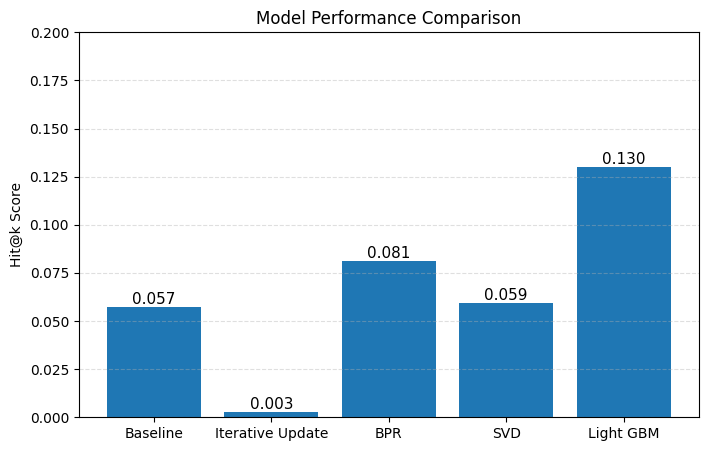

In [47]:
import matplotlib.pyplot as plt

model_names = ["Baseline", "Iterative Update", "BPR", "SVD", "Light GBM"]
scores = [base_score, iter_score, bpr_score, svd_score, light_gbm_score]

plt.figure(figsize=(8,5))
bars = plt.bar(model_names, scores)

plt.ylabel("Hit@k Score")
plt.title("Model Performance Comparison")
plt.ylim(0, 0.2)  # hit rates are between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Add numeric labels above bars
for bar, score in zip(bars, scores):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f"{score:.3f}",
        ha='center',
        va='bottom',
        fontsize=11
    )

plt.savefig("model_compr_score.png")
plt.show()


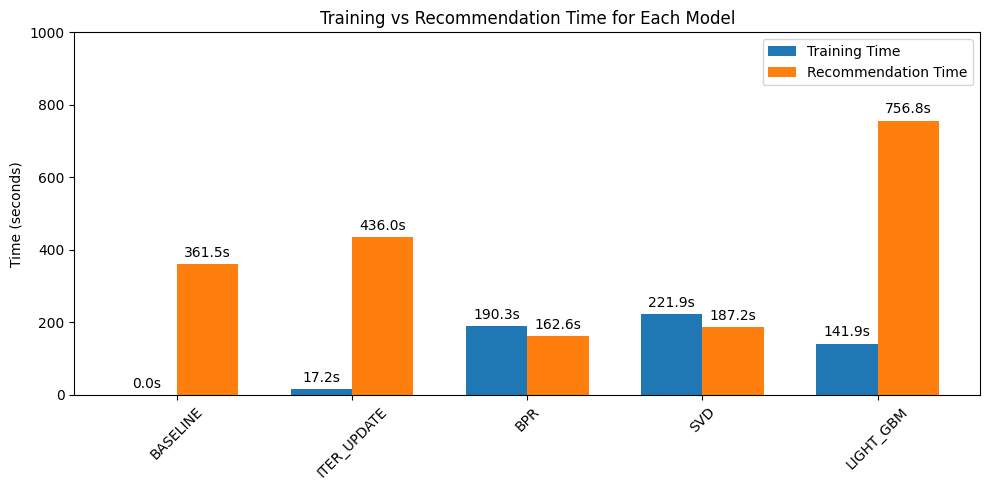

In [48]:
models = ["BASELINE", "ITER_UPDATE", "BPR",  "SVD", "LIGHT_GBM"]

train_times = [train_time.get(m, 0) for m in models]
rec_times   = [rec_time.get(m, 0) for m in models]

x = np.arange(len(models))  # positions for models
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(10,5))

# Two bars per model
bars_train = ax.bar(x - width/2, train_times, width, label='Training Time')
bars_rec   = ax.bar(x + width/2, rec_times, width, label='Recommendation Time')

# Add labels on top of each bar
for bars in [bars_train, bars_rec]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}s',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom')

ax.set_ylabel('Time (seconds)')
plt.ylim(0, 1000)
ax.set_title('Training vs Recommendation Time for Each Model')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45)
ax.legend()
plt.tight_layout()
plt.savefig("times.png")
plt.show()

In [ ]:
def score_by_review_count(model_hits, user_interaction_counts, min_users=5):
    """
    Returns a dict mapping:
        num_reviews -> average hit rate for users with that many reviews
    
    min_users: minimum number of users required to display a bucket 
               (prevents noisy very-small buckets)
    """
    from collections import defaultdict

    bucket = defaultdict(list)

    # Put each user's hit into the bucket for their review count
    for user, hit in model_hits.items():
        n_reviews = user_interaction_counts.get(user, 0)
        bucket[n_reviews].append(hit)

    # Compute average hit rate per review-count bucket
    result = {}
    for n_reviews, hits in bucket.items():
        if len(hits) >= min_users:  # avoid noisy 1-user buckets
            result[n_reviews] = sum(hits) / len(hits)

    return result


# Unused Models

## Linear Regression

In [ ]:
# # Feature vector
# def feature(datum):
#     feat = [1]

#     # The features that make sense to see:
#     # price, latitude/longitude, description length, num_of_reviews

#     feat.append(len(datum["price"]) if datum["price"] else 0)
#     # feat.append(datum["latitude"])
#     # feat.append(datum["longitude"])

#     feat.append(len(datum["description"]) if datum["description"] else 0)
#     feat.append(datum["num_of_reviews"])

#     # Days open
#     days_open = [0] * 7

#     if datum["hours"]:
#         for d in datum["hours"]:
#             if d[0] == "Monday" and str.lower(d[1]) != "closed":
#                 days_open[0] = 1
#             if d[0] == "Tuesday" and str.lower(d[1]) != "closed":
#                 days_open[1] = 1
#             if d[0] == "Wednesday" and str.lower(d[1]) != "closed":
#                 days_open[2] = 1
#             if d[0] == "Thursday" and str.lower(d[1]) != "closed":
#                 days_open[3] = 1
#             if d[0] == "Friday" and str.lower(d[1]) != "closed":
#                 days_open[4] = 1
#             if d[0] == "Saturday" and str.lower(d[1]) != "closed":
#                 days_open[5] = 1
#             if d[0] == "Sunday" and str.lower(d[1]) != "closed":
#                 days_open[6] = 1

#     feat += days_open

#     # Categories
#     # cat_one_hot = [0] * len(list(cats))
    
#     # if datum["category"]:
#     #     for c in datum["category"]:
#     #         cat_one_hot[cats[c]] = 1

#     # feat += cat_one_hot

#     # Planning
#     # plannings_one_hot = [0] * len(list(plannings))
#     # if datum["MISC"] and "Planning" in datum["MISC"] and datum["MISC"]["Planning"]:
#     #     for p in datum["MISC"]["Planning"]:
#     #         plannings_one_hot[plannings[p]] = 1
    
#     # feat += plannings_one_hot

#     # Payment
#     # payments_one_hot = [0] * len(list(payments))
#     # if datum["MISC"] and "Payments" in datum["MISC"] and datum["MISC"]["Payments"]:
#     #     for p in datum["MISC"]["Payments"]:
#     #         payments_one_hot[payments[p]] = 1
    
#     # feat += payments_one_hot

#     return feat

In [ ]:
# # Implement and predict

# y = numpy.array([d["avg_rating"] for d in train_metadata])

# x = numpy.array([feature(d) for d in train_metadata])

# # Setting up the logistic regression using sklearn library (class weight is balanced)
# regr = linear_model.LinearRegression()

# # Train the model using feature = x, label = y
# regr.fit(x, y)

# # Now predict if we feed the model another feature (x)
# x_test = numpy.array([feature(d) for d in metadata])

# y_train_prediction = regr.predict(x_test)

# loc_and_pred = []

# for i in range(len(x_test)):
#     loc_and_pred.append((y_train_prediction[i], metadata[i]["gmap_id"]))

# loc_and_pred.sort(reverse=True)

# popularity_list_id = [b for a, b in loc_and_pred]

# # Building the dictionary to feed to the evaluation function (same as baseline)
# # recommendation[user_id] = [top k items the model recommend]
# recommendation = {}

# # Get each user that has reviewed
# for review in reviews:
#     user_id = review["user_id"]

#     # Recommend the top number of hidden reviews for each user
#     if user_id not in recommendation:
#         # Filter the popularity list so that the users' revealed likes isn't included here
#         filtered_popularity_list = []

#         for name in popularity_list_id:
#             if name not in users_revealed_likes[user_id]:
#                 filtered_popularity_list.append(name)

#             if len(filtered_popularity_list) == k:
#                 break

#         recommendation[user_id] = filtered_popularity_list[:k]

# loader.save_likes("linear_regression_recommendation_per_user.json", recommendation)

## Light FM Model

In [18]:
# from lightfm import LightFM
# from lightfm.data import Dataset

# start_time = time.time()

# #build dataset
# dataset = Dataset()
# dataset.fit(
#     users=range(num_users),
#     items=range(num_items)
# )

# # Build interaction matrix
# import scipy.sparse as sp
# rows = []
# cols = []

# for u, i, r in interactions_train:
#     rows.append(u)
#     cols.append(i)

# train_matrix = sp.csr_matrix(
#     (numpy.ones(len(rows)), (rows, cols)),
#     shape=(num_users, num_items)
# )

# #create model
# model_lfm = LightFM(
#     no_components=LATENT_DIM,
#     loss="bpr",           # or "warp" (often better)
#     learning_rate=LEARNING_RATE,
# )

# # model fit
# model_lfm.fit(
#     train_matrix,
#     epochs=20,
#     num_threads=4
# )

# end_time = time.time()
# train_time["LIGHT_FM"] = end_time - start_time

In [19]:
# def get_top_k_recommendations_lightfm(
#     model, train_items_per_user, test_items_per_user,
#     k, idx_to_user_id, idx_to_item_id
# ):
#     recs = {}
#     users = list(test_items_per_user.keys())

#     for u in tqdm(users, desc="LightFM recommendations"):
#         user_id = idx_to_user_id[u]

#         # Mask out training items
#         train_items = train_items_per_user[u]
#         candidate_items = [
#             i for i in range(num_items)
#             if i not in train_items
#         ]

#         if not candidate_items:
#             recs[user_id] = []
#             continue

#         # Predict scores
#         scores = model.predict(
#             user_ids=u,
#             item_ids=candidate_items
#         )

#         top_idx = numpy.argsort(-scores)[:k]
#         top_items = [candidate_items[i] for i in top_idx]

#         recs[user_id] = [idx_to_item_id[i] for i in top_items]

#     return recs

# start_time = time.time()

# recs_lightfm = get_top_k_recommendations_lightfm(
#     model_lfm,
#     items_per_user_train,
#     test_items_per_user,
#     TOP_K,
#     idx_to_user_id,
#     idx_to_item_id
# )

# save_likes(LIGHT_FM_REC_FNAME, recs_lightfm)

# end_time = time.time()
# rec_time["LIGHT_FM"] = end_time - start_time

LightFM recommendations: 100%|███████████████████████████████████████████████████| 38800/38800 [01:26<00:00, 450.95it/s]


Saved to  eval/light_fm_recommendation_per_user.json
